Import statements from Matt

In [1]:
import astropy
from astropy.io import fits
import numpy as np 
import textwrap
import matplotlib.pyplot as plt
import os, sys 
import importlib
import glob
from tqdm import tqdm


from astropy.time import Time
from astropy.units import allclose as quantity_allclose
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates.builtin_frames import FK5, ICRS, GCRS, GeocentricMeanEcliptic, BarycentricMeanEcliptic, HeliocentricMeanEcliptic, GeocentricTrueEcliptic, BarycentricTrueEcliptic, HeliocentricTrueEcliptic, HeliocentricEclipticIAU76
from astropy.constants import R_sun, R_earth
from astropy.wcs import WCS

import fitsio


# -------------------------------------------------------------------------------------
# Local imports
# -------------------------------------------------------------------------------------
sys.path.append(os.path.join(os.path.split(os.getcwd())[0], 'shifty'))
import known
import downloader

importlib.reload(known)
importlib.reload(downloader)


<module 'downloader' from '/Users/matthewjohnpayne/Envs/shifty/shifty/downloader.py'>

In [2]:
import astropy 
astropy.__version__ , astropy.__path__

('4.0',
 ['/Users/matthewjohnpayne/opt/anaconda3/lib/python3.7/site-packages/astropy'])

In [3]:
# Some notes on which camera/ccd/etc we expect Sedna to be in 
# - These came from inputing 57.136 7.6549 into lightkurve's tess-cut/tess-search function 
camera = 1 
ccd = 4
col, row = 1550, 1101

In [4]:
importlib.reload(known)
K = known.Known()

# These are the values from JPL at hourly intervals
JD_, RA_, Dec_  = K._radec_for_sedna()
for t,r,d in zip(JD_[:2], RA_[:2], Dec_[:2]):
    print(t,r,d)
print()

# Plot the positions across the course of the November 2019 (Sector-5) period  
RA_, Dec_ = K._interpolate_radec_for_sedna(JD_)
#plt.plot(JD_, RA_ , '.')
#plt.plot(JD_, Dec_ , '.')

2458436.5 57.1364 7.65498
2458436.541666667 57.13601 7.65487



In [5]:
import eleanor

I'm going to pick a random target where near Sedna is expected to be to get the timestamps and quality flags for sector 5. If you already have these, just set them as variables instead.

In [6]:
star = eleanor.Source(tic=468899671, sector=5) # for sedna
#star = eleanor.Source(tic=649903630, sector=5) # for 101

INFO: Found cached file /Users/matthewjohnpayne/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-1-4-cal-1588-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-1-4-cal-1588-1078_tess_v2_bkg.fits with expected size 73658880. [astroquery.query]
INFO: Found cached file /Users/matthewjohnpayne/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-1-4-cal-1588-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-1-4-cal-1588-1078_tess_v2_pc.fits with expected size 147421440. [astroquery.query]


In [7]:
data = eleanor.TargetData(star)

Set DATE-BEG to '2018-11-15T11:38:52.334' from MJD-BEG'. [astropy.wcs.wcs]


In [8]:
data.time

array([1437.99575975, 1438.01659318, 1438.03742662, ..., 1464.22447545,
       1464.24530799, 1464.26614053])

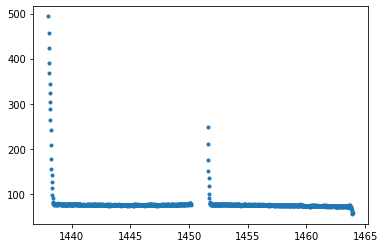

In [40]:
q = data.quality == 0

plt.plot(data.time[q], data.raw_flux[q], '.')

In [10]:
times = data.time[q] + 0.0

In [11]:
def get_sedna_shifts(tvals):
    x, y = [], []
    ralist, declist = [], []
    times = []
    for i in range(len(tvals)):
        jd = 2457000 + tvals[i]
        ra, dec = known.Known()._interpolate_radec_for_sedna(jd)
        crd = SkyCoord(ra, dec, unit='deg')
        #pixel = WCS(hdr).world_to_pixel(crd)
        #x.append(int(pixel[0]))
        #y.append(int(pixel[1]))
        ralist.append(ra)
        declist.append(dec)
        times.append(jd)
    return np.array(tuple(zip(x, y))), np.array(tuple(zip(ralist, declist))), times

def get_101_shifts(tvals):
    x, y = [], []
    ralist, declist = [], []
    times = []
    for i in range(len(tvals)):
        jd = 2457000 + tvals[i]
        ra, dec = known.Known()._interpolate_radec_for_101583(jd)
        crd = SkyCoord(ra, dec, unit='deg')
        #pixel = WCS(hdr).world_to_pixel(crd)
        #x.append(int(pixel[0]))
        #y.append(int(pixel[1]))
        ralist.append(ra)
        declist.append(dec)
        times.append(jd)
    return np.array(tuple(zip(x, y))), np.array(tuple(zip(ralist, declist))), times

let's get predicted RA and Dec for Sedna at each cadence

In [12]:
_, locs, t_vals = get_sedna_shifts(times)

In [13]:
locs[300]

array([57.05547879,  7.63669815])

In [14]:
from tqdm import tnrange
from tess_stars2px import tess_stars2px_function_entry


And then we'll use Chris Burke's tess-point tool to convert these coordinates at each cadence to a pixel position at each cadence.

In [15]:
x, y = [], []

for j in tnrange(len(locs)):

    ra = locs[j,0]
    dec = locs[j,1]
    ticid = 8675309
    outID, outEclipLong, outEclipLat, outSec, outCam, outCcd, \
        outColPix, outRowPix, scinfo = tess_stars2px_function_entry(
                ticid, ra, dec)

    x.append(outColPix[0])
    y.append(outRowPix[0])
    

/Users/matthewjohnpayne/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


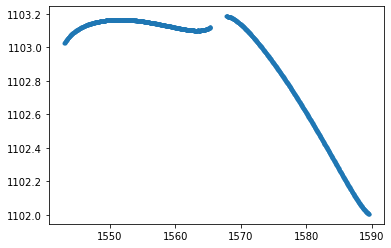

In [16]:
plt.plot(x,y, '.')

Let's get a postcard that covers this part of the sky

In [17]:
data.post_obj

eleanor postcard (/Users/matthewjohnpayne/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-1-4-cal-1588-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-1-4-cal-1588-1078_tess_v2_pc.fits)

In [18]:
from astropy.io import fits

In [19]:
a = fits.open('/Users/matthewjohnpayne/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-1-4-cal-1588-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-1-4-cal-1588-1078_tess_v2_pc.fits')
bkg_ = fits.open('/Users/matthewjohnpayne/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0005-1-4-cal-1588-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0005-1-4-cal-1588-1078_tess_v2_bkg.fits')


And then let's use it. At each cadence, draw a 27x27 region from the postcard centered on the expected position of Sedna. We'll subtract off the median of the 100 cadences on either side of the postcard frame to use as a median model of what the stars are doing. Then stack up these shifted frames. For coding convenience/laziness I'm only selecting the region when this entire TPF would fall onto the postcard, and excluding the first and last 100 frames for median calculations, but there's no reason we couldn't do both of those more properly.

We could also pre-compute the median frames and do that calculation much more quickly than I'm doing it here.

It would also be good to split up the two orbits, right now the last 100 frames of the first orbit include median information from the first 100 cadences of the second orbit, where we know the pointing is different.

In [34]:
size = len(a[2].data[q])
runmed = np.zeros(a[2].data[q].shape)
output = np.zeros((size, 53,53))
#bkgput = np.zeros((size, 53,53))

for i in tnrange(100, size-100):

    a1 = int(np.round((x[i]-1588) + 148/2, 0))
    a2 = int(np.round((y[i]-1078) + 104/2, 0))
    
    #print(a1, a2)
    
    if ((a1 > 27) and (a1 < 121) and (a2 > 27) and (a2 < 121)):  
        #print(i)
        runmed[i] = np.nanmedian(a[2].data[q][i-100:i+100], axis=(0))
        medsub = a[2].data[q][i] - runmed[i]

        #plt.clf()
        #plt.imshow(medsub, vmin=-1, vmax=1, origin='lower')
        #plt.plot(a1,a2, 'rx', alpha=0.9, markersize=16)
        #print(a1, a2)
        #plt.savefig('frames/%04i.png'%i)
        output[i] = medsub[a2-26:a2+27, a1-26:a1+27] 
        #output[i] = a[2].data[q][i,a2-26:a2+27, a1-26:a1+27] 
        #bkgput[i] = bkg_[1].data[q][i,a1-26:a1+27, a2-26:a2+27]

/Users/matthewjohnpayne/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


In [38]:
print(' data shape ', a[2].data[q].shape)
print(' output shape ', output.shape)
print(' runmed shape ', runmed.shape)
print( ' output-sum ' ,np.sum(output))
print( ' runmed-sum ' ,np.sum(runmed))


 data shape  (1162, 104, 148)
 output shape  (1162, 53, 53)
 runmed shape  (1162, 104, 148)
 output-sum  175733.0269317627
 runmed-sum  422784297.4356766


Do we see Sedna?

flux1 shape  (350, 53, 53)
  flux1 min, max  -25.26513671875 42.653656005859375
   flux1 sum  -6659.674255371094
outvar1    shape  (53, 53)
outvar1 min, max  -305.1159210205078 101.52298736572266
 outvar1 sum  -6659.674255371094


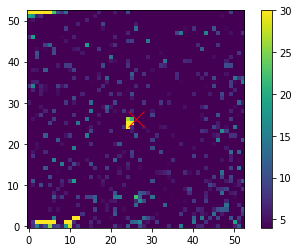

In [37]:
flux1 = output[150:500] #- bkgput[150:500] +0.0 #+ bkgput[50:500]
outvar1 = np.sum(flux1, axis=(0))

flux2 = output[800:1100] #- bkgput[800:1100] +0.0 #+ bkgput[700:1100]
outvar2 = np.sum(flux2, axis=(0))

#outvar = outvar1 + outvar2

outvar = np.sum(output, axis=(0))


plt.imshow(outvar1, vmin=4.00, vmax=30.00, origin='lower')

plt.plot(26,26, 'rx', alpha=0.9, markersize=16)

plt.colorbar()

print('flux1 shape ',      flux1.shape)
print('  flux1 min, max ', np.min(flux1) , np.max(flux1))
print('   flux1 sum ',      np.sum(flux1) )
print('outvar1    shape ', outvar1.shape)
print('outvar1 min, max ', np.min(outvar1) , np.max(outvar1))
print(' outvar1 sum ',      np.sum(outvar1) )


Oh shit we do! And it's not a systematic like a cosmic ray, if we chunk the first and second half of the data we see it in each.

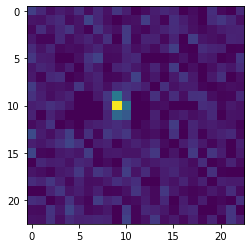

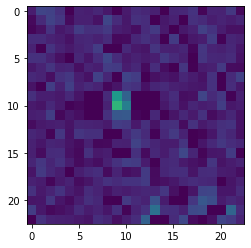

In [23]:
plt.imshow(outvar1[15:38,15:38], vmin=-10.00, vmax=100.00)
plt.show()
plt.imshow(outvar2[15:38,15:38], vmin=-10.00, vmax=100.00)
plt.show()

Now let's take a cheeky look to see if we can measure a rotation period. There's some discrepancy in the literature.

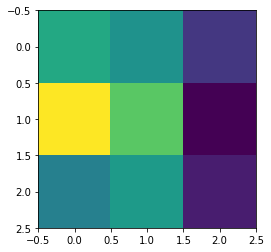

In [24]:
plt.imshow(outvar[24:27,24:27])

In [25]:
from lightkurve.lightcurve import LightCurve as LC

In [32]:
sap_flux = np.sum(output[:,24:27,24:27], axis=(1,2))

In [53]:
lk = LC(times[100:-100], sap_flux[100:-100]).remove_outliers(sigma=2.0).bin(99)

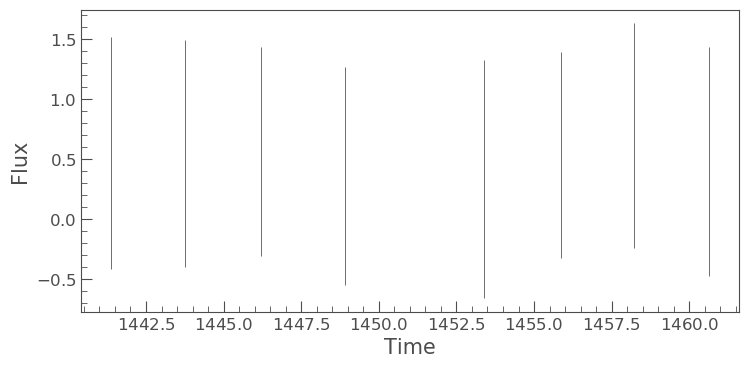

In [54]:
lk.errorbar()


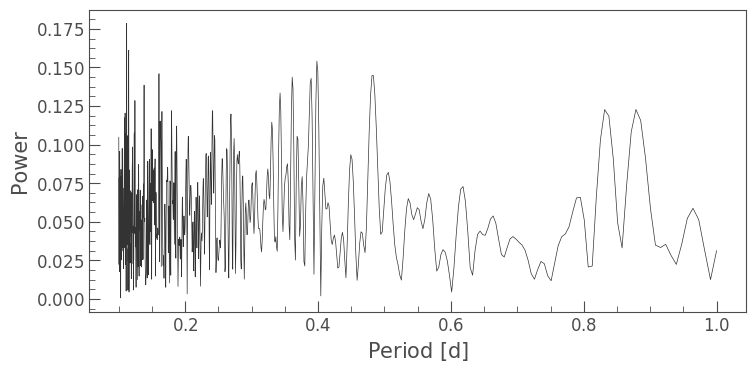

In [28]:
lk.to_periodogram(minimum_period=0.1, maximum_period=1.0).plot()


In [29]:
lk.to_periodogram(minimum_period=0.4, maximum_period=0.5).period_at_max_power

<Quantity 0.48222851 d>

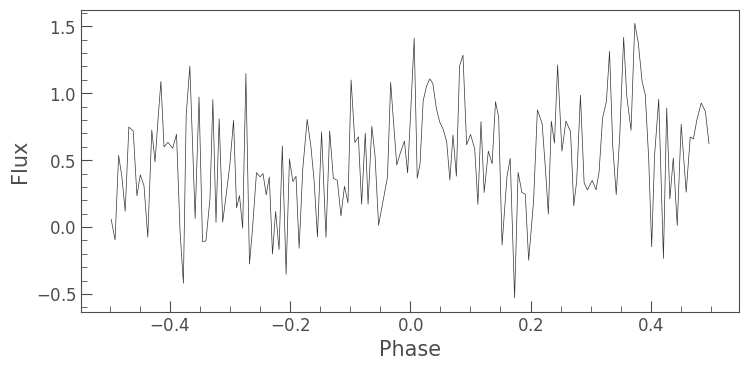

In [30]:
lk.fold(lk.to_periodogram(minimum_period=0.4, maximum_period=0.5).period_at_max_power).bin(5).plot()

That actually looks somewhat variable, but the power spectrum isn't significant, and by doing slightly different outlier removal we can get a very different result, so I don't quite believe this.